In [38]:
import simpy 
import numpy as np
import random
import matplotlib.pyplot as plt

In [56]:
"""
Bank renege example

Covers:

- Resources: Resource
- Condition events

Scenario:
  A counter with a random service time and customers who renege. Based on the
  program bank08.py from TheBank tutorial of SimPy 2. (KGM)

"""
import random

import simpy


RANDOM_SEED = 42
NEW_CUSTOMERS = 10000 # Total number of customers
LAMBD = 1/12
MU = 1/11
waiting_times= []
service_times = []

def source(env, number, lambd, counter):
    """Source generates customers randomly"""
    t0 = np.random.exponential(1/lambd) # Arrival time of first customer
    yield env.timeout(t0)

    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counter, MU)
        env.process(c)
        t = np.random.exponential(1/lambd)
        yield env.timeout(t)


def customer(env, name, counter, mu):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req: 
        yield req
        wait = env.now - arrive
        waiting_times.append(wait)
        print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
        service_time = np.random.exponential(1/mu)
        service_times.append(service_time)

        yield env.timeout(service_time)
        print('%7.4f %s: Finished' % (env.now, name))
        

# Setup and start the simulation
print('M/M/1 queue')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, LAMBD, counter))
env.run()

M/M/1 queue
 8.5530 Customer00: Here I am
 8.5530 Customer00: Waited  0.000
15.0397 Customer00: Finished
20.5078 Customer01: Here I am
20.5078 Customer01: Waited  0.000
28.5047 Customer02: Here I am
39.8630 Customer03: Here I am
48.6973 Customer01: Finished
48.6973 Customer02: Waited 20.193
55.4381 Customer02: Finished
55.4381 Customer03: Waited 15.575
59.2202 Customer03: Finished
59.9314 Customer04: Here I am
59.9314 Customer04: Waited  0.000
64.4946 Customer04: Finished
105.7712 Customer05: Here I am
105.7712 Customer05: Waited  0.000
113.0452 Customer06: Here I am
115.4989 Customer07: Here I am
118.2258 Customer08: Here I am
131.0729 Customer05: Finished
131.0729 Customer06: Waited 18.028
137.4682 Customer06: Finished
137.4682 Customer07: Waited 21.969
147.2729 Customer07: Finished
147.2729 Customer08: Waited 29.047
147.7504 Customer08: Finished
162.9352 Customer09: Here I am
162.9352 Customer09: Waited  0.000
166.7942 Customer09: Finished
169.4143 Customer10: Here I am
169.4143 Cus

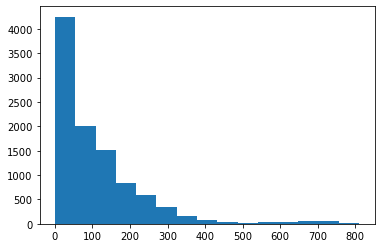

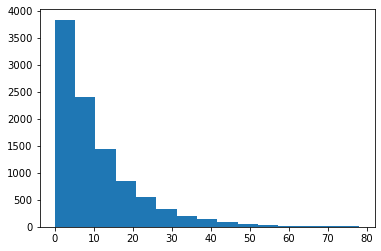

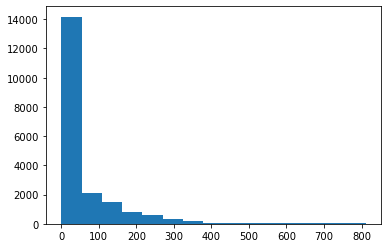

In [57]:
sojourn_time = waiting_times + service_times
plt.hist(waiting_times, bins = 15)
plt.show()
plt.hist(service_times, bins = 15)
plt.show()
plt.hist(sojourn_time, bins = 15)
plt.show()

In [58]:
rho = LAMBD/MU
print(f'Theoretical mean waiting time = {(rho/MU)/(1/rho)}')
print(f'Empirical mean waiting time = {np.mean(waiting_times)}')

Theoretical mean waiting time = 9.243055555555554
Empirical mean waiting time = 107.85546388128239


In [13]:
"""
Bank renege example

Covers:

- Resources: Resource
- Condition events

Scenario:
  A counter with a random service time and customers who renege. Based on the
  program bank08.py from TheBank tutorial of SimPy 2. (KGM)

"""
import random

import simpy


RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience


def source(env, number, interval, counter):
    """Source generates customers randomly"""
    for i in range(number):
        c = customer(env, 'Customer%02d' % i, counter, time_in_bank=12.0)
        env.process(c)
        t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter, time_in_bank):
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))

            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            print('%7.4f %s: Finished' % (env.now, name))

        else:
            # We reneged
            print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))


# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 3.8595 Customer00: Finished
10.2006 Customer01: Here I am
10.2006 Customer01: Waited  0.000
12.7265 Customer02: Here I am
13.9003 Customer02: RENEGED after  1.174
23.7507 Customer01: Finished
34.9993 Customer03: Here I am
34.9993 Customer03: Waited  0.000
37.9599 Customer03: Finished
40.4798 Customer04: Here I am
40.4798 Customer04: Waited  0.000
43.1401 Customer04: Finished
